In [ ]:
import pandas as pd
import swifter

arxiv_word_counts = pd.read_json('../data/clean/arxiv_word_counts.json',lines=True)
arxiv_word_counts = arxiv_word_counts.drop(columns=['text'])

nyt_word_counts = pd.read_json('../data/clean/nyt_word_counts.json',lines=True)
nyt_word_counts = nyt_word_counts.drop(columns=['text'])

product_word_counts = pd.read_json('../data/clean/prod_hunt_word_counts.json',lines=True)
product_word_counts = product_word_counts.drop(columns=['text'])

dfs = {
    'arxiv': arxiv_word_counts,
    'nyt': nyt_word_counts,
    'producthunt': product_word_counts
}


# Make aesthetic

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_aesthetic(hex_color_list=None, 
	with_gridlines=False, 
	bold_title=False, 
	save_transparent=False, 
	font_scale=2, 
	latex2arial = True
	):
    """Make Seaborn look clean and add space between title and plot"""
    
    # Note: To make some parts of title bold and others not bold, we have to use
    # latex rendering. This should work: 
    # plt.title(r'$\mathbf{bolded\ title}$' + '\n' + 'And a non-bold subtitle')

    
    sns.set(style='white', context='paper', font_scale=font_scale)
    if not hex_color_list:
		    # 2024-11-28: Reordered color list
        hex_color_list = [
            "#2C3531",  # Dark charcoal gray with green undertone
            "#D41876",  # Telemagenta
            "#00A896",  # Persian green
            "#826AED",  # Medium slate blue
            "#F45B69",  # Vibrant pinkish-red
            "#E3B505",  # Saffron
            "#89DAFF",  # Pale azure
            "#342E37",  # Dark grayish-purple
            "#7DCD85",  # Emerald
            "#F7B2AD",  # Melon
            "#D4B2D8",  # Pink lavender
            "#020887",  # Phthalo blue
            "#E87461",  # Medium-bright orange
            "#7E6551",  # Coyote
            "#F18805"   # Tangerine
        ]
    
    sns.set_palette(sns.color_palette(hex_color_list))

    # Update on 
    # 2024-11-29: I realized I can automatically 
    # clean variable names so i dont have to manually replace underscore
    
    # Enhanced typography settings
    plt.rcParams.update({
        # font settings
        'font.family': 'Arial',
        'font.weight': 'regular',
        'axes.labelsize': 11 * font_scale,
        'axes.titlesize': 14 * font_scale,
        'xtick.labelsize': 10 * font_scale,
        'ytick.labelsize': 10 * font_scale,
        'legend.fontsize': 10 * font_scale,
        
        # spines/grids
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.linewidth': 0.8,  # Thinner spines
        'axes.grid': with_gridlines,
        'grid.alpha': 0.2,       
        'grid.linestyle': ':', 
        'grid.linewidth': 0.5,
        
        # title
        'axes.titlelocation': 'left',
        'axes.titleweight': 'bold' if bold_title else 'regular',
        'axes.titlepad': 15 * (font_scale / 1),
        
        # fig
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'figure.constrained_layout.use': True,
        'figure.constrained_layout.h_pad': 0.2,
        'figure.constrained_layout.w_pad': 0.2,
        
        # legend
        'legend.frameon': True,
        'legend.framealpha': 0.95,
        'legend.facecolor': 'white',
        'legend.borderpad': 0.4,
        'legend.borderaxespad': 1.0,
        'legend.handlelength': 1.5,
        'legend.handleheight': 0.7,
        'legend.handletextpad': 0.5,
        
        # export
        'savefig.dpi': 300,
        'savefig.transparent': save_transparent,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.2,
        'figure.autolayout': False,
        
         # do this for the bold hack
        'mathtext.fontset': 'custom',
        'mathtext.rm': 'Arial',
        'mathtext.it': 'Arial:italic',
        'mathtext.bf': 'Arial:bold'

    })
    
    return hex_color_list

def clean_vars(s, how='title'):
    """
    Simple function to clean titles

    Params
    - s: The string to clean
    - how (default='title'): How to return string. Can be either ['title', 'lowercase', 'uppercase']

    Returns
    - cleaned string
    """
    assert how in ['title', 'lowercase', 'uppercase'], "Bad option!! see docs"
    s = re.sub('([a-z0-9])([A-Z])', r'\1 \2', s)
    s = s.replace('_', ' ')
    if how == 'title':
        return s.title()
    elif how=='lower':
        return s.lower()
    elif how=='upper':
    	return s.upper()



mypal = make_aesthetic()



# Process dfs

In [35]:
class TFIDFCalculator:
    


    """
    A class to calculate TF-IDF scores for a DataFrame column containing word count dictionaries.
    """
    

    
    def __init__(self, df, word_count_column, N=None):
        """
        Initialize the TF-IDF calculator.
        
        Args:
            df (pd.DataFrame): The input DataFrame
            word_count_column (str): Name of the column containing word count dictionaries
            N (int, optional): Total number of documents to use in IDF calculation. 
                             If None, uses count of non-null documents in the DataFrame.
        """
        self.df = df.copy()
        self.word_count_column = word_count_column
        self.custom_N = N
        self.idf_scores = {}
        self.N = 0
        
    def calculate_tfidf(self):
        """
        Calculate TF-IDF scores and add them to the DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame with added TF-IDF columns
        """
        # Step 1: Calculate Document Frequency (DF)
        self._calculate_document_frequencies()
        
        # Step 2: Calculate IDF scores
        self._calculate_idf_scores()
        
        # Step 3: Calculate TF-IDF for each row
        self._calculate_row_tfidf()
        
        return self.df
    
    def _calculate_document_frequencies(self):
        """Calculate how many documents each word appears in."""
        doc_counts_per_word = Counter()
        valid_word_counts = self.df[self.word_count_column].dropna()
        
        for wc_dict in valid_word_counts:
            if isinstance(wc_dict, dict) and wc_dict:
                doc_counts_per_word.update(wc_dict.keys())
        
        self.doc_counts_per_word = doc_counts_per_word
        # Use custom N if provided, otherwise count non-null documents
        self.N = self.custom_N if self.custom_N is not None else len(self.df[self.df[self.word_count_column].notna()])
    
    def _calculate_idf_scores(self):
        """Calculate smoothed exponential IDF scores that emphasize unique terms."""
        alpha = 2 # Adjust: 1.0 = no boost, 2.0 = strong boost
        for word in self.doc_counts_per_word.keys():
            df_term = self.doc_counts_per_word[word]
            # Smoothed exponential IDF
            raw_idf = ((self.N + 1) / (df_term + 1)) ** alpha + 1
            self.idf_scores[word] = min(raw_idf, 1000)  # Cap extreme values
    
    def _calculate_row_tfidf(self):
        """Calculate TF-IDF scores for each row and add to DataFrame."""
        tfidf_column = f"{self.word_count_column}_tfidf"
        sum_tfidf_column = f"sum_{self.word_count_column}_tfidf"
        
        self.df[tfidf_column] = self.df[self.word_count_column].swifter.apply(self._calculate_single_row_tfidf)
        self.df[sum_tfidf_column] = self.df[tfidf_column].swifter.apply(
            lambda x: sum(x.values()) if isinstance(x, dict) else 0
        )
    
    def _calculate_single_row_tfidf(self, row_word_counts):
        """
        Calculate TF-IDF scores for a single row's word counts.
        
        Args:
            row_word_counts (dict): Dictionary of word counts for a single document
            
        Returns:
            dict: Dictionary of TF-IDF scores for each word
        """
        if not isinstance(row_word_counts, dict) or not row_word_counts:
            return {}
        
        total_words_in_doc = sum(row_word_counts.values())
        if total_words_in_doc == 0:
            return {}
        
        row_tfidf = {}
        for word, count in row_word_counts.items():
            tf = count / total_words_in_doc
            idf = self.idf_scores.get(word, 0)
            row_tfidf[word] = tf * idf
        
        return row_tfidf
    

dfs = {
   'arxiv': arxiv_word_counts,
   'nyt': nyt_word_counts,
   'producthunt': product_word_counts
}

byday = {}

for name, df in dfs.items():

   
   # get only ai
   df = df.query("ai_binary ==1")
   
   # dt
   df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
   df['total_count'] = 1
   
   calculator = TFIDFCalculator(df, "social_word_counts", N=df.query("social_word_counts.notna()").shape[0])
   df = calculator.calculate_tfidf()
   
   df['ai_compound_sum'] = df['ai_compound_roles_sum'] + df['ai_compound_nouns_sum']
   df['ai_compound_binary'] = df['ai_compound_sum'].swifter.apply(lambda x: 1 if x > 0 else 0)
   
   # Convert count columns to int
   sum_cols = [col for col in df.columns if "sum" in col]
   for col in sum_cols:
       df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
       df[f"{col}_mean"] = df[col]
       
   # Convert binary columns to int
   binary_cols = [col for col in df.columns if "binary" in col]
   for col in binary_cols:
       df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
       df[f"{col}_sum"] = df[col]
       
   print(f"Dataset: {name}")
   print(f"Number of rows: {len(df)}")
   print(f"Number of columns: {len(df.columns)}")
   print(f"Columns: {df.columns.tolist()}")
   
   # Group by date and aggregate
   df_grouped = df.groupby(by=['dt']).agg({
       **{col: 'sum' for col in sum_cols},  # Sum for count columns
       **{col: 'mean' for col in binary_cols},  # Mean for binary columns, 
       **{f"{col}_mean": 'mean' for col in sum_cols},  # Mean for count columns
       **{f"{col}_sum": 'sum' for col in binary_cols},  # Sum for binary columns
       'total_count': 'sum'  # Sum for the total_count column
   }).reset_index()
   
   
   byday[name] = df_grouped

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_11618/1167911098.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_11618/1167911098.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/99487 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99487 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/99487 [00:00<?, ?it/s]

Dataset: arxiv
Number of rows: 99487
Number of columns: 38
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'analysis_date', 'unique_idx', 'text', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'ai_sum_mean', 'social_sum_mean', 'ai_compound_roles_sum_mean', 'ai_compound_nouns_sum_mean', 'ai_compound_sum_mean', 'sum_social_word_counts_tfidf_mean', 'base-ai_binary_sum', 'ai_binary_sum', 'social_binary_sum', 'ai_compound_roles_binary_sum', 'ai_compound_nouns_binary_sum', 'ai_compound_binary_sum']


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_11618/1167911098.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_11618/1167911098.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2008 [00:00<?, ?it/s]

Dataset: nyt
Number of rows: 2008
Number of columns: 38
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'analysis_date', 'unique_idx', 'text', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'ai_sum_mean', 'social_sum_mean', 'ai_compound_roles_sum_mean', 'ai_compound_nouns_sum_mean', 'ai_compound_sum_mean', 'sum_social_word_counts_tfidf_mean', 'base-ai_binary_sum', 'ai_binary_sum', 'social_binary_sum', 'ai_compound_roles_binary_sum', 'ai_compound_nouns_binary_sum', 'ai_compound_binary_sum']


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_11618/1167911098.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_11618/1167911098.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_count'] = 1


Pandas Apply:   0%|          | 0/43427 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/43427 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/43427 [00:00<?, ?it/s]

Dataset: producthunt
Number of rows: 43427
Number of columns: 38
Columns: ['base-ai_word_counts', 'ai_word_counts', 'social_word_counts', 'ai_compound_roles_word_counts', 'ai_compound_nouns_word_counts', 'ai_compound_word_counts', 'base-ai_sum', 'ai_sum', 'social_sum', 'ai_compound_roles_sum', 'ai_compound_nouns_sum', 'ai_compound_sum', 'base-ai_binary', 'ai_binary', 'social_binary', 'ai_compound_roles_binary', 'ai_compound_nouns_binary', 'ai_compound_binary', 'analysis_date', 'unique_idx', 'text', 'dt', 'total_count', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf', 'base-ai_sum_mean', 'ai_sum_mean', 'social_sum_mean', 'ai_compound_roles_sum_mean', 'ai_compound_nouns_sum_mean', 'ai_compound_sum_mean', 'sum_social_word_counts_tfidf_mean', 'base-ai_binary_sum', 'ai_binary_sum', 'social_binary_sum', 'ai_compound_roles_binary_sum', 'ai_compound_nouns_binary_sum', 'ai_compound_binary_sum']


# Plot ts (individual)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

def plot_ts(name, col, smoothing=False, period='daily', figsize=(12, 6)):
   """
   Plot time series for a given dataset and column.
   
   Parameters:
   -----------
   name : str
       Dataset name (key in byday dictionary)
   col : str
       Column name to plot
   smoothing : bool or int
       If True, applies 7-day rolling average. If int, uses that window size.
   period : str
       Aggregation period: 'daily', 'weekly', 'monthly', 'yearly'
   figsize : tuple
       Figure size (width, height)
   """
   
   clean_col = col.replace('_', ' ').title()
   if col == 'ai_compound_sum':
       clean_col = "Synthetic Social Learning Hits"
       
   
   source_dict = {
         'arxiv': 'arXiv',
         'nyt': 'NYT',
         'producthunt': 'Product Hunt'
   }
   clean_source = source_dict.get(name)
   if clean_col.startswith("Ai"):
         clean_col = clean_col.replace("Ai", "AI")
   
   if name not in byday:
       raise ValueError(f"Dataset '{name}' not found. Available: {list(byday.keys())}")
   
   df = byday[name].copy()
   
   if col not in df.columns:
       raise ValueError(f"Column '{col}' not found. Available: {df.columns.tolist()}")
   
   # Resample based on period
   if period == 'daily':
       df_plot = df.set_index('dt').resample('D')[col].sum().reset_index()
   elif period == 'weekly':
       df_plot = df.set_index('dt').resample('W')[col].mean().reset_index()
   elif period == 'monthly':
       df_plot = df.set_index('dt').resample('M')[col].mean().reset_index()
   elif period == 'yearly':
       df_plot = df.set_index('dt').resample('Y')[col].mean().reset_index()
   else:
       raise ValueError("Period must be 'daily', 'weekly', 'monthly', or 'yearly'")
   
   # Apply smoothing if requested
   if smoothing:
       window = 7 if smoothing is True else int(smoothing)
       df_plot[f'{col}_smooth'] = df_plot[col].rolling(window=window, center=True).mean()
       plot_col = f'{col}_smooth'
       line_label = f'{col} ({window}-period moving average)'
   else:
       plot_col = col
       line_label = col
   
   # Create plot
   plt.figure(figsize=figsize)
   plt.plot(df_plot['dt'], df_plot[plot_col])
   
   # Formatting
   plt.title(f'{clean_source} | {clean_col} ({period.title()})',  fontweight='bold')
   plt.xlabel('Date')
   plt.ylabel(col.replace('_', ' ').title())
   
   plt.xticks(rotation=45)
   plt.tight_layout()
   

   
   return df_plot

# Example usage:
for source in ['arxiv', 'producthunt', 'nyt']:
    for dv in ['social_sum', 'ai_compound_sum', 'social_binary']:
            for period in ['monthly', 'yearly']:
                print(f"Plotting {source} - {dv} ({period})")
                plot_ts(source, dv, smoothing=False, period=period)
                plt.show()




it has # grid plot

In [ ]:
sorted(byday['arxiv'].columns)

# Grid plot of all time series

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_11618/1039787986.py:75: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=2.0)


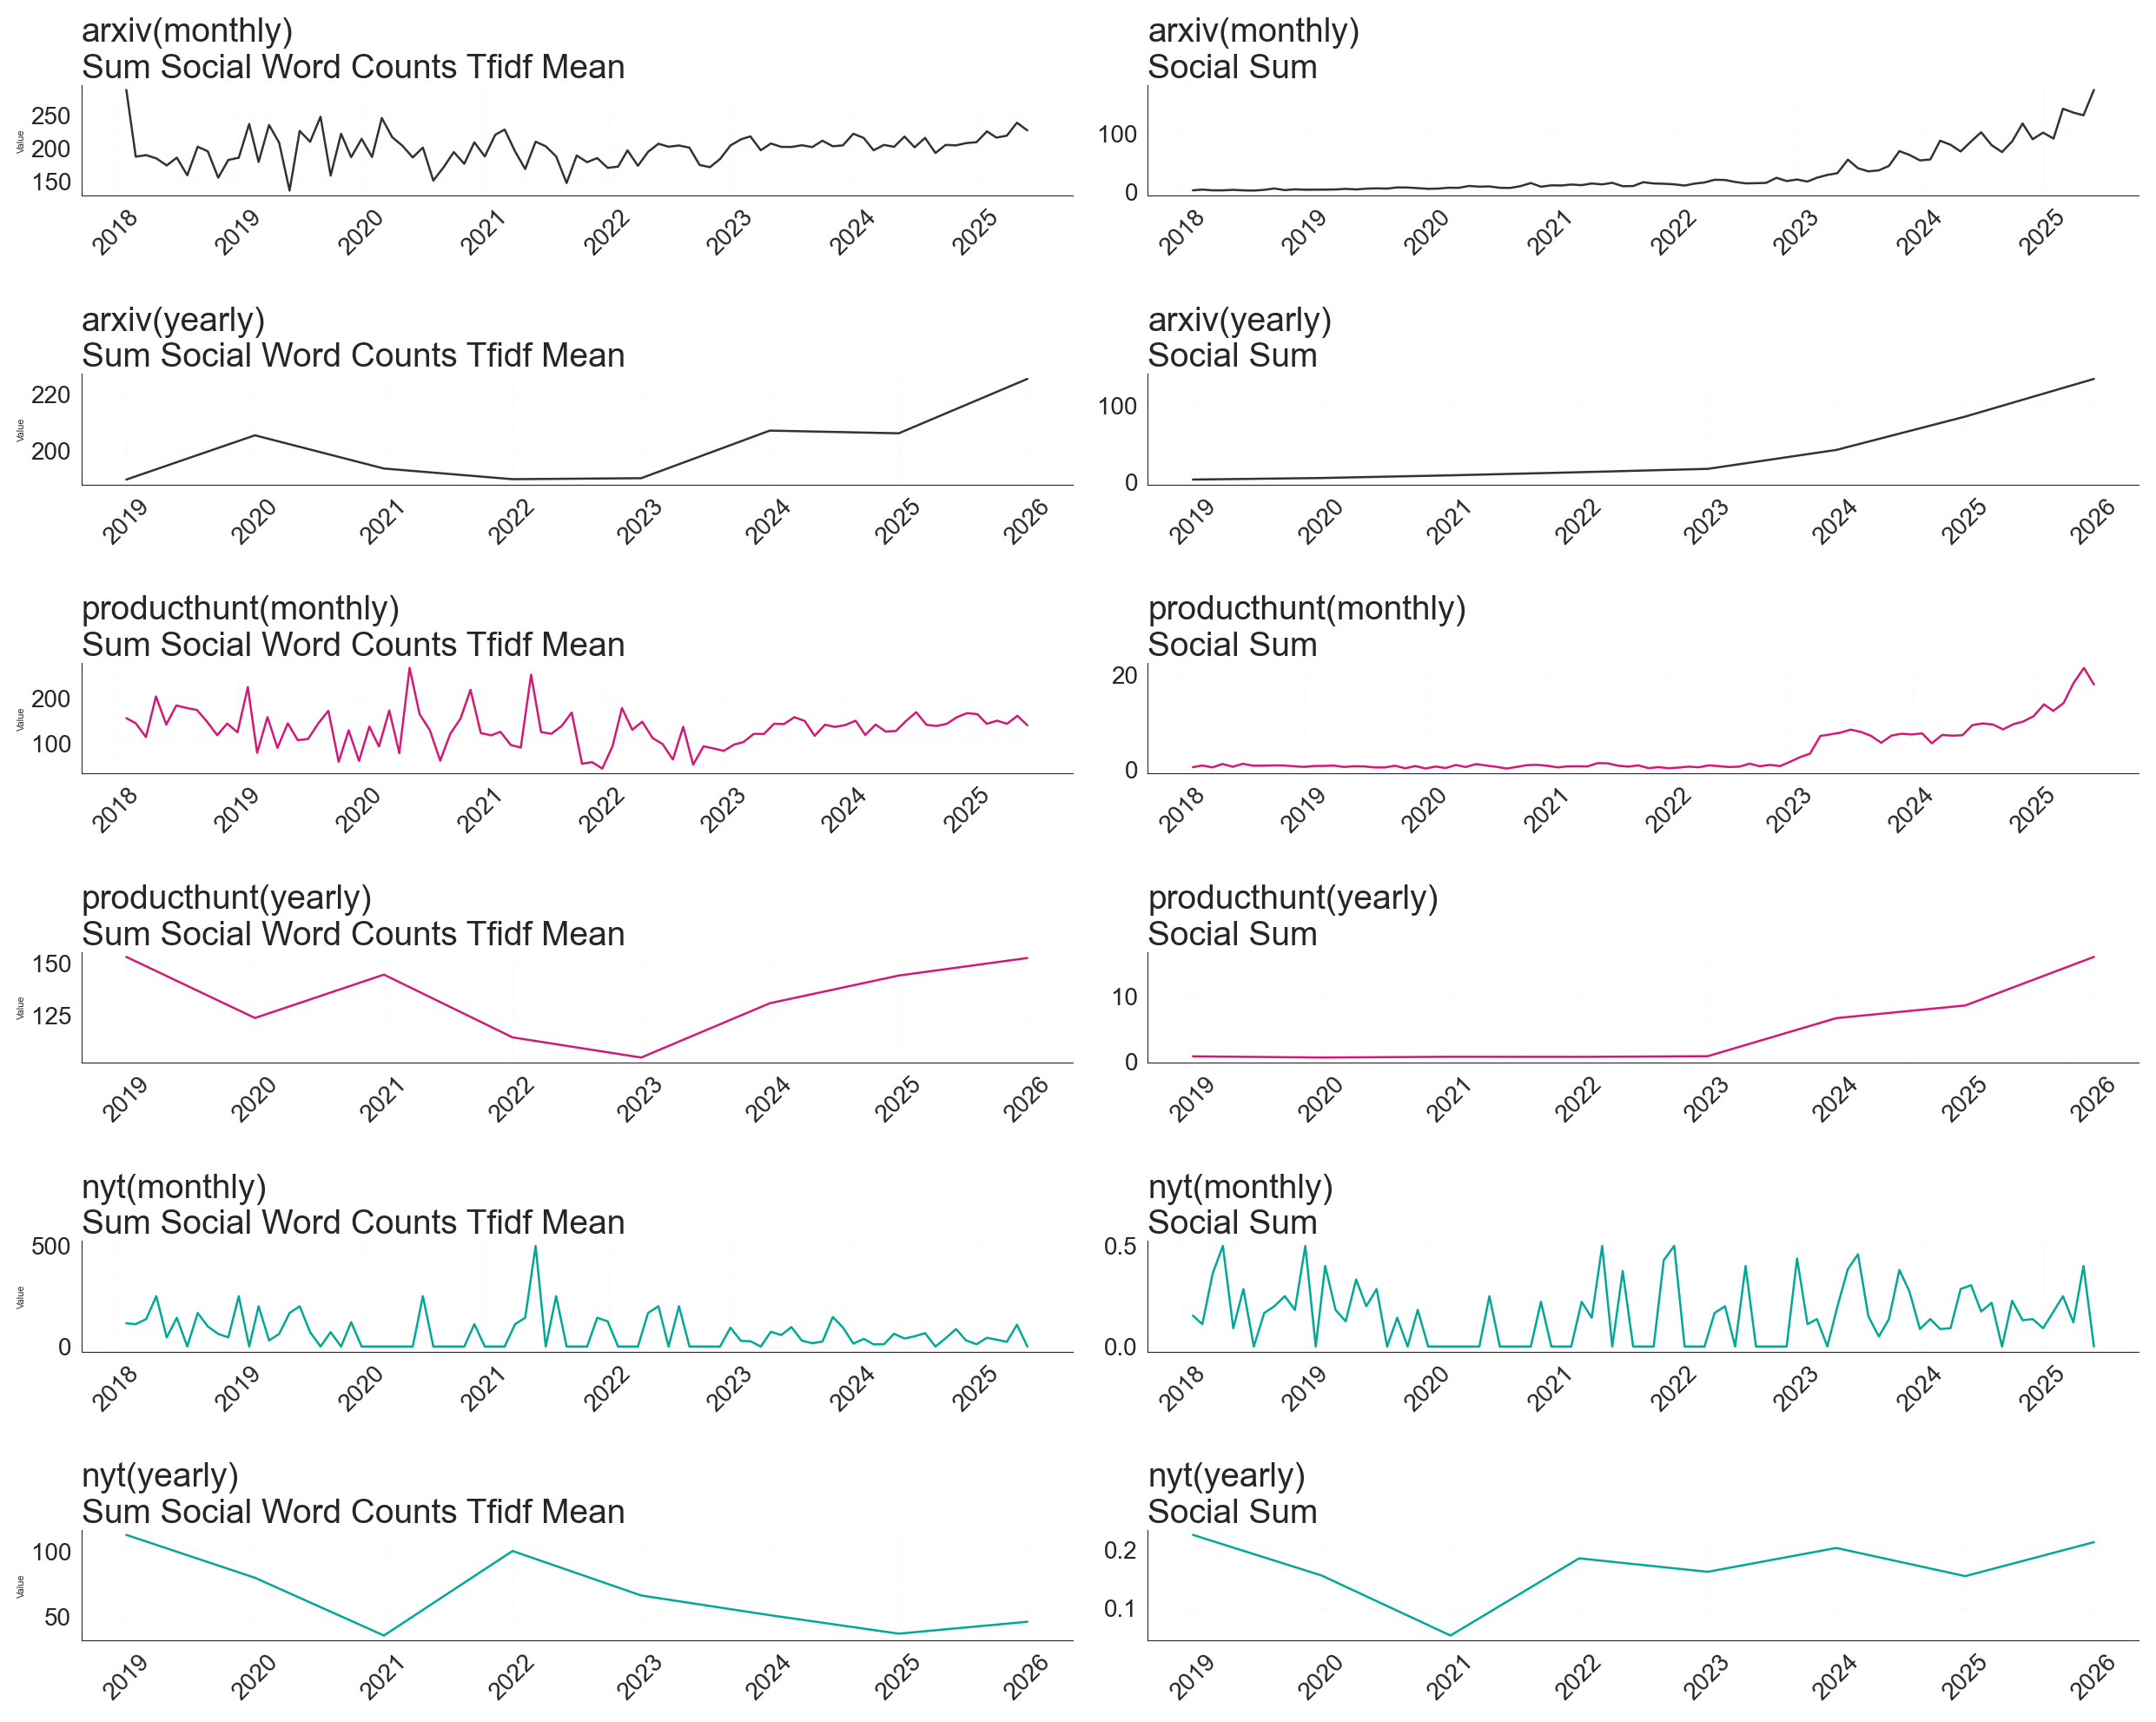

✅  Saved grid to all_time_series.png


In [37]:
import matplotlib.pyplot as plt
import sys
import os

from src.helpers import make_aesthetic

mypal = make_aesthetic()

def save_all_ts_grid(
    sources=('arxiv', 'producthunt', 'nyt'),
    dvs=('sum_social_word_counts_tfidf_mean', 'social_sum'),
    periods=('monthly', 'yearly'),
    smoothing=False,                 # or e.g. 7 for a 7-day MA
    figsize=(25, 20),                # tweak as needed
    dpi=300,                         # high-resolution
    out_fn='all_time_series.png'
):
    """
    Saves a grid of time-series plots (source × period × DV) to `out_fn`.
    Assumes `byday` is in scope and `plot_ts()` is defined.
    """
    n_rows = len(sources) * len(periods)   
    n_cols = len(dvs)                      
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=False, sharey=False)
    
    color_map = {
        'arxiv': mypal[0],
        'producthunt': mypal[1],
        'nyt': mypal[2],
    }

    axes_iter = axes.reshape(-1, n_cols)

    for r, (source, period) in enumerate(
        [(s, p) for s in sources for p in periods]   # keeps the grid order stable
    ):
        for c, dv in enumerate(dvs):
            ax = axes_iter[r, c]

            df = byday[source].copy()

            # Aggregate to the requested period
            if period == 'daily':
                df_plot = df.set_index('dt').resample('D')[dv].sum().reset_index()
            elif period == 'weekly':
                df_plot = df.set_index('dt').resample('W')[dv].mean().reset_index()
            elif period == 'monthly':
                df_plot = df.set_index('dt').resample('M')[dv].mean().reset_index()
            elif period == 'yearly':
                df_plot = df.set_index('dt').resample('Y')[dv].mean().reset_index()
            else:
                raise ValueError("period must be 'daily', 'weekly', 'monthly', or 'yearly'")

            # Optional smoothing
            plot_col = dv
            if smoothing:
                window = 7 if smoothing is True else int(smoothing)
                df_plot[f'{dv}_smooth'] = df_plot[dv].rolling(window, center=True).mean()
                plot_col = f'{dv}_smooth'

            # Draw
            ax.plot(df_plot['dt'], df_plot[plot_col], linewidth=1.8, color=color_map[source])
            clean_dv = dv.replace('_', ' ').title()
            ax.set_title(f'{source}({period})\n{clean_dv}', pad=6)
            ax.tick_params(axis='x', rotation=45)
            ax.tick_params(axis='y')
            ax.grid(alpha=0.3)

            # Light y-label only on leftmost column
            if c == 0:
                ax.set_ylabel('Value', fontsize=8)

    fig.tight_layout(h_pad=2.0)
    plt.show()
    fig.savefig(out_fn, dpi=dpi, bbox_inches='tight')
    plt.close(fig)
    print(f"✅  Saved grid to {out_fn}")

save_all_ts_grid()


/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_11618/3246039034.py:166: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=2.0, w_pad=1.0)


✅  Saved grid to all_time_series.png


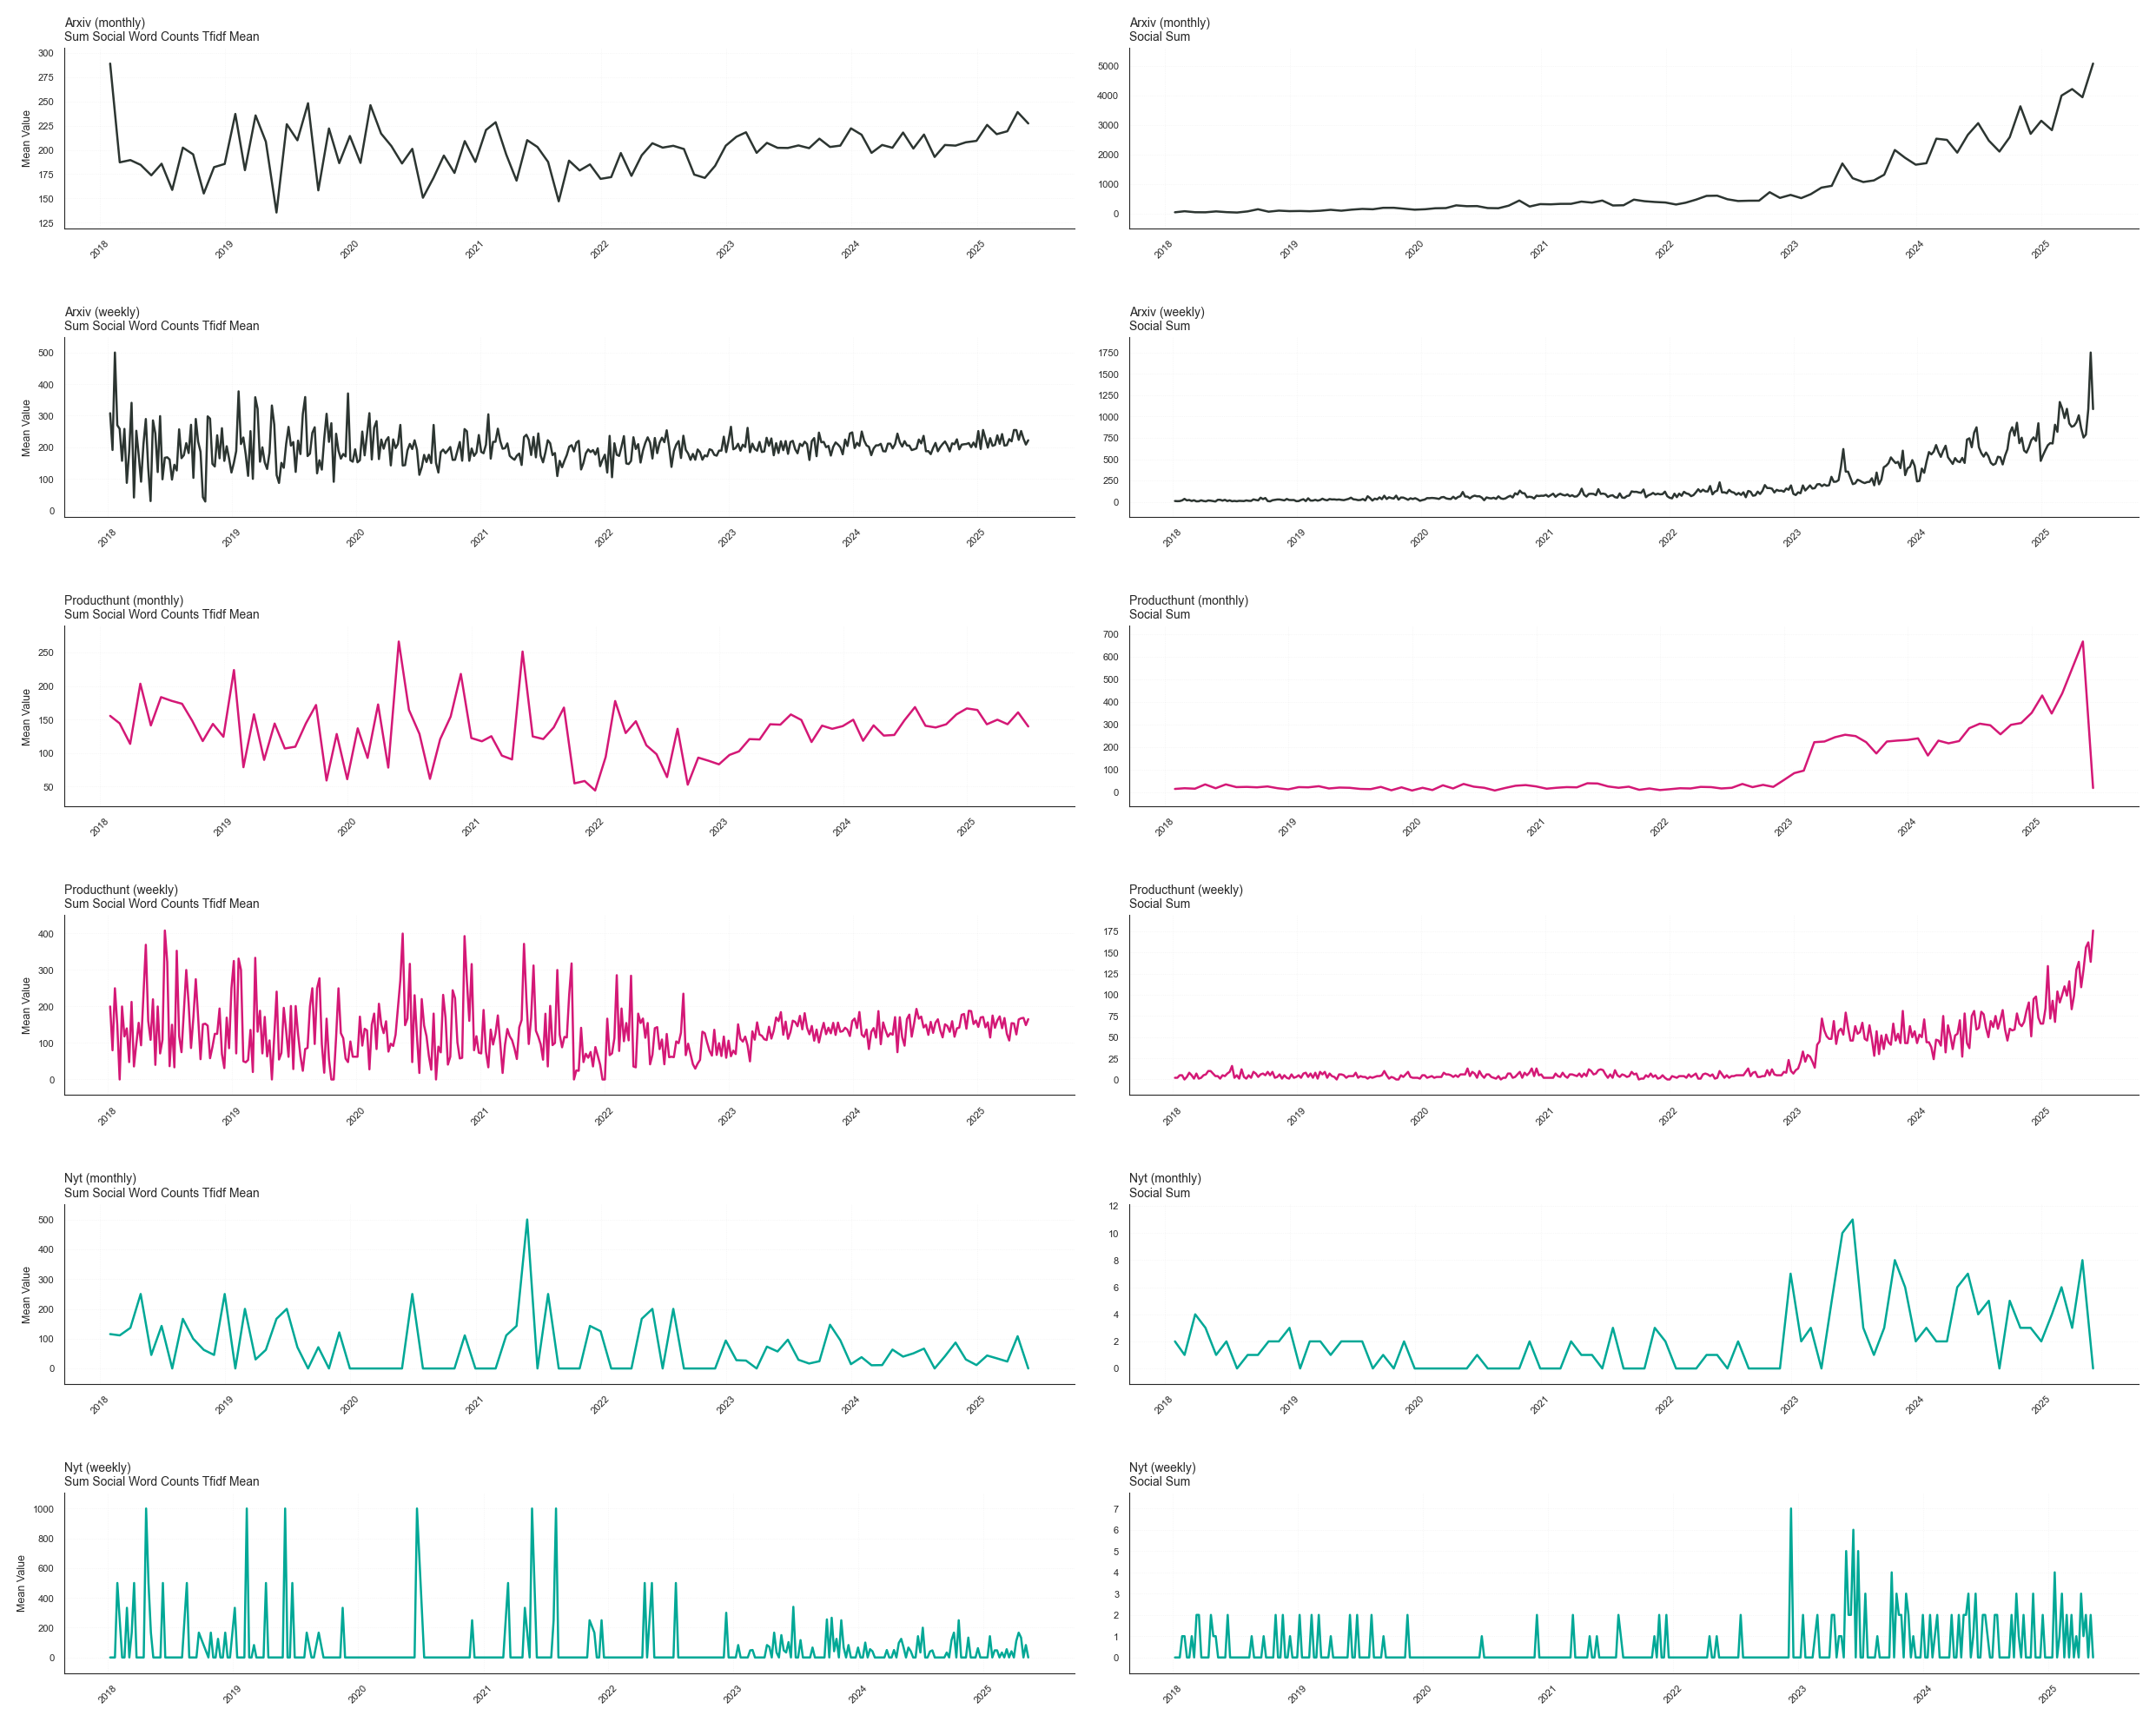

In [41]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os


def save_all_ts_grid(
    byday_dict,                      # Pass byday as parameter
    sources=('arxiv', 'producthunt', 'nyt'),
    dvs=('sum_social_word_counts_tfidf_mean', 'social_sum'),
    periods=('monthly', "weekly"),
    smoothing=False,                 # or e.g. 7 for a 7-day MA
    figsize=(25, 20),                # tweak as needed
    dpi=300,                         # high-resolution
    out_fn='all_time_series.png'
):
    """
    Saves a grid of time-series plots (source × period × DV) to `out_fn`.
    
    Args:
        byday_dict: Dictionary containing DataFrames for each source
        sources: Tuple of source names to plot
        dvs: Tuple of dependent variables (column names) to plot
        periods: Tuple of time periods for aggregation
        smoothing: False, True (7-day default), or integer for window size
        figsize: Figure size tuple
        dpi: Resolution for saved figure
        out_fn: Output filename
    """
    
    # Validate inputs
    for source in sources:
        if source not in byday_dict:
            raise ValueError(f"Source '{source}' not found in byday_dict")
    
    mypal = make_aesthetic()
    
    n_rows = len(sources) * len(periods)   
    n_cols = len(dvs)                      
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=False, sharey=False)
    
    # Handle single subplot case
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    color_map = {
        'arxiv': mypal[0],
        'producthunt': mypal[1], 
        'nyt': mypal[2],
    }
    
    # Add more colors if needed
    for i, source in enumerate(sources):
        if source not in color_map:
            color_map[source] = mypal[i % len(mypal)]

    axes_iter = axes.reshape(-1, n_cols)

    for r, (source, period) in enumerate(
        [(s, p) for s in sources for p in periods]   # keeps the grid order stable
    ):
        for c, dv in enumerate(dvs):
            ax = axes_iter[r, c]

            try:
                df = byday_dict[source].copy()
                
                # Check if column exists
                if dv not in df.columns:
                    ax.text(0.5, 0.5, f'Column {dv}\nnot found', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                    continue
                
                # Ensure dt is datetime
                if not pd.api.types.is_datetime64_any_dtype(df['dt']):
                    df['dt'] = pd.to_datetime(df['dt'])
                
                # Determine aggregation method based on column name
                if 'sum' in dv.lower() and 'mean' not in dv.lower():
                    agg_method = 'sum'
                elif 'binary' in dv.lower() and 'sum' not in dv.lower():
                    agg_method = 'mean'  # For proportions
                elif 'mean' in dv.lower():
                    agg_method = 'mean'
                elif 'count' in dv.lower():
                    agg_method = 'sum'
                else:
                    agg_method = 'mean'  # Default fallback

                # Aggregate to the requested period
                df_indexed = df.set_index('dt')
                
                if period == 'daily':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('D')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('D')[dv].mean().reset_index()
                elif period == 'weekly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('W')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('W')[dv].mean().reset_index()
                elif period == 'monthly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('M')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('M')[dv].mean().reset_index()
                elif period == 'yearly':
                    if agg_method == 'sum':
                        df_plot = df_indexed.resample('Y')[dv].sum().reset_index()
                    else:
                        df_plot = df_indexed.resample('Y')[dv].mean().reset_index()
                else:
                    raise ValueError("period must be 'daily', 'weekly', 'monthly', or 'yearly'")

                # Remove any NaN values
                df_plot = df_plot.dropna()
                
                if len(df_plot) == 0:
                    ax.text(0.5, 0.5, 'No data\navailable', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                    continue

                # Optional smoothing
                plot_col = dv
                if smoothing and len(df_plot) > 2:
                    window = 7 if smoothing is True else int(smoothing)
                    window = min(window, len(df_plot))  # Don't exceed data length
                    df_plot[f'{dv}_smooth'] = df_plot[dv].rolling(window, center=True, min_periods=1).mean()
                    plot_col = f'{dv}_smooth'

                # Draw the line
                ax.plot(df_plot['dt'], df_plot[plot_col], 
                       linewidth=1.8, color=color_map.get(source, mypal[0]))
                
                # Format title and labels
                clean_dv = dv.replace('_', ' ').title()
                ax.set_title(f'{source.title()} ({period})\n{clean_dv}', pad=6, fontsize=10)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', labelsize=8)
                ax.grid(alpha=0.3)

                # Add some padding to y-axis
                y_min, y_max = ax.get_ylim()
                y_range = y_max - y_min
                ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)

                # Light y-label only on leftmost column
                if c == 0:
                    ax.set_ylabel(f'{agg_method.title()} Value', fontsize=9)
                    
            except Exception as e:
                # Handle errors gracefully
                ax.text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=8)
                ax.set_title(f'{source} ({period})\n{dv}', pad=6)
                print(f"Warning: Error plotting {source}-{period}-{dv}: {e}")

    fig.tight_layout(h_pad=2.0, w_pad=1.0)
    
    # Save before showing to avoid issues
    fig.savefig(out_fn, dpi=dpi, bbox_inches='tight')
    print(f"✅  Saved grid to {out_fn}")
    
    plt.show()
    plt.close(fig)

save_all_ts_grid(byday)

# TopWords

In [ ]:
import pandas as pd
import swifter

arxiv_word_counts = pd.read_json('../data/clean/arxiv_word_counts.json',lines=True)

nyt_word_counts = pd.read_json('../data/clean/nyt_word_counts.json',lines=True)

product_word_counts = pd.read_json('../data/clean/prod_hunt_word_counts.json',lines=True)

dfs = {
    'arxiv': arxiv_word_counts,
    'nyt': nyt_word_counts,
    'producthunt': product_word_counts
}


In [ ]:
arxiv = dfs['arxiv']

In [ ]:
df = arxiv.copy().query("ai_binary == 1").reset_index(drop=True)
import pandas as pd
import numpy as np
from collections import Counter
import swifter # For parallel processing of apply

# --- Sample DataFrame Setup ---
# Ensure this DataFrame structure matches yours, especially the 'social_word_counts' column.

# --- End Sample DataFrame Setup ---

# --- Step 1: Calculate Document Frequency (DF) from 'social_word_counts' ---

dv = "social_word_counts"

# STEP 1: CALC DFs
doc_counts_per_word = Counter()
valid_social_word_counts = df[dv].dropna()
for wc_dict in valid_social_word_counts:
    if isinstance(wc_dict, dict) and wc_dict:
        doc_counts_per_word.update(wc_dict.keys()) # Count each word's presence in a document

N = len(df.query("social_word_counts.notna()")) 


# STEP 2: CALC IDFS
idf_scores = {}
all_unique_words = doc_counts_per_word.keys()

for word in all_unique_words:
    df_term = doc_counts_per_word[word]
    idf_scores[word] = np.log((N + 1) / (df_term + 1)) + 1

print(f"IDF Scores from 'social_word_counts':\n{idf_scores}\n")


def calculate_row_tfidf(row_word_counts, global_idf_scores):
    """
    Calculates TF-IDF scores for a single row's word_counts.
    """
    if not isinstance(row_word_counts, dict) or not row_word_counts:
        return {} # Return empty dict for empty, None, NaN, or invalid input

    total_words_in_doc = sum(row_word_counts.values())
    if total_words_in_doc == 0: # Handles cases like {'word': 0}
        return {}

    row_tfidf = {}
    for word, count in row_word_counts.items():
        tf = count / total_words_in_doc
        idf = global_idf_scores.get(word, 0) # Default to 0 if word somehow not in IDF scores
                                            # (shouldn't happen if DF/IDF calculated from same corpus)
        row_tfidf[word] = tf * idf
        
    return row_tfidf


df['social_tfidf_scores'] = df['social_word_counts'].swifter.apply(lambda wc: calculate_row_tfidf(wc, idf_scores))
df['sum_social_tfidf_scores'] = df['social_tfidf_scores'].swifter.apply(lambda x: sum(x.values()) if isinstance(x, dict) else 0)
print("TF-IDF calculation complete.\n")

# Display the DataFrame with the new TF-IDF scores
print("DataFrame with TF-IDF scores for 'social_word_counts':")


# You can also view it as:
# print(df[['id', 'social_word_counts', 'social_tfidf_scores']])


In [ ]:
import pandas as pd

import pandas as pd
import numpy as np
from collections import Counter
import swifter
    


# Usage examples:
# 
# 1. Use automatic N (count of non-null documents):
calculator = TFIDFCalculator(dfs['arxiv'], "social_word_counts", N=len(dfs['arxiv'].query("social_word_counts.notna()")))
result_df = calculator.calculate_tfidf()
#
# 2. Use custom N (e.g., from a larger corpus):
# calculator = TFIDFCalculator(df, "social_word_counts", N=10000)
# result_df = calculator.calculate_tfidf()
#
# print(result_df[['social_word_counts', 'social_word_counts_tfidf', 'sum_social_word_counts_tfidf']])

In [ ]:
result_df

In [ ]:
df['dt'] = pd.to_datetime(df['analysis_date'], format='%Y-%m-%d', errors='coerce')
df = df.set_index('dt')

In [ ]:
# Resample the data to monthly frequency and calculate the mean
df.resample("M")['sum_social_tfidf_scores'].mean().plot()



In [ ]:
# Resample the data to monthly frequency and calculate the mean
df['ai_compound_roles_binary'].resample("W").mean().rolling(40).mean().plot()


In [ ]:
df.columns

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
from collections import defaultdict
import itertools

class SSLKeywordGenerator:
    """
    Generate SSL keywords using masked language models
    """
    
    def __init__(self, model_name="bert-large-uncased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.model.eval()
    
    def generate_keywords(self, template, top_k=20):
        """
        Generate keywords by masking tokens in template
        
        Args:
            template: String with [MASK] token
            top_k: Number of top predictions to return
        """
        # Tokenize
        inputs = self.tokenizer(template, return_tensors="pt")
        
        # Find mask token position
        mask_token_index = torch.where(inputs["input_ids"] == self.tokenizer.mask_token_id)[1]
        
        # Get predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = outputs.logits
        
        # Get top k predictions for mask position
        mask_predictions = predictions[0, mask_token_index, :]
        top_k_tokens = torch.topk(mask_predictions, top_k, dim=1)
        
        # Convert to words
        keywords = []
        for token_id in top_k_tokens.indices[0]:
            token = self.tokenizer.decode([token_id]).strip()
            keywords.append(token)
        
        return keywords

def create_ssl_templates():
    """
    Refined templates with stronger social context to guide masked LM predictions
    Each template explicitly primes for social/interpersonal content
    """
    
    templates = {
        "belonging": [
            # Strong social relationship context
            "I asked ChatGPT for dating [MASK] and it really helped me connect with people",
            "The AI gave me relationship [MASK] that improved my social connections"
        ],
        
        "understanding": [
            # Clear norm/etiquette context
            "I was confused about social [MASK] so I asked the AI to explain proper behavior", 
            "The chatbot helped me understand cultural [MASK] in professional settings"
        ],
        
        "controlling": [
            # Explicit social situation management
            "I have a difficult [MASK] tomorrow so I'm asking AI for conversation strategies",
            "The AI helped me plan how to navigate workplace [MASK] with my colleagues"
        ],
        
        "selfEnhancing": [
            # Clear social skill/confidence context
            "I want to improve my social [MASK] so I asked the AI for interpersonal advice",
            "The chatbot is helping me become more [MASK] in social situations"
        ],
        
        "trusting": [
            # Emotional support context
            "I told the AI about my relationship [MASK] and it provided emotional support",
            "When I'm feeling socially [MASK] I talk to ChatGPT for comfort and guidance"
        ]
    }
    
    return templates

def run_systematic_generation():
    """
    Run systematic keyword generation across all motives and templates
    """
    
    generator = SSLKeywordGenerator()
    templates = create_ssl_templates()
    
    all_keywords = defaultdict(list)
    
    print("SYSTEMATIC MASKED LM KEYWORD GENERATION")
    print("======================================")
    
    for motive, template_list in templates.items():
        print(f"\n{motive.upper()} MOTIVE:")
        print("-" * 30)
        
        motive_keywords = set()
        
        for template in template_list:
            print(f"\nTemplate: {template}")
            
            try:
                keywords = generator.generate_keywords(template, top_k=15)
                
                # Filter for relevant terms (basic filtering)
                relevant_keywords = [kw for kw in keywords 
                                   if len(kw) > 2 and kw.isalpha()]
                
                motive_keywords.update(relevant_keywords)
                
                print(f"Keywords: {', '.join(relevant_keywords[:10])}")
                
            except Exception as e:
                print(f"Error with template: {e}")
        
        all_keywords[motive] = list(motive_keywords)
    
    return all_keywords

def create_bidirectional_templates():
    """
    Expert bidirectional templates that mask both AI terms and social content
    Based on realistic usage patterns
    """
    
    bidirectional_templates = [
        # How people actually describe getting social help from AI
        "I got relationship advice from [MASK] and it was surprisingly good",
        "When I'm struggling socially, [MASK] gives me perspective", 
        "I use [MASK] as my therapist because it's always available",
        
        # What people actually ask AI about  
        "I asked AI about [MASK] and learned so much about myself",
        "ChatGPT helped me navigate [MASK] better than my friends could",
        "I turn to AI when I need help with [MASK] situations"
    ]
    
    return bidirectional_templates

def validate_generated_keywords(keywords_by_motive):
    """
    Much stricter validation focused on SSL-relevant terms
    """
    
    # Strong SSL indicators - terms that clearly relate to social learning
    ssl_indicators = [
        # Relationship terms
        'dating', 'relationship', 'romantic', 'marriage', 'friendship', 'family',
        # Social skills  
        'communication', 'conversation', 'social', 'interpersonal', 'networking',
        # Emotional/psychological
        'confidence', 'anxiety', 'depression', 'stress', 'emotional', 'feelings',
        # Social situations
        'interview', 'presentation', 'meeting', 'conflict', 'negotiation', 'leadership',
        # Cultural/normative
        'etiquette', 'manners', 'behavior', 'norms', 'customs', 'appropriate',
        # Support/guidance
        'advice', 'guidance', 'support', 'help', 'coaching', 'therapy'
    ]
    
    validated_keywords = {}
    
    for motive, keywords in keywords_by_motive.items():
        # Only keep keywords that are clearly SSL-related
        relevant = []
        for keyword in keywords:
            # Must contain SSL indicator or be common social term
            if any(indicator in keyword.lower() for indicator in ssl_indicators):
                relevant.append(keyword)
            # Also check if it's a clear social/emotional adjective
            elif keyword.lower() in ['confident', 'shy', 'outgoing', 'assertive', 'empathetic', 
                                   'charismatic', 'articulate', 'persuasive', 'diplomatic']:
                relevant.append(keyword)
        
        validated_keywords[motive] = relevant
    
    return validated_keywords

def extract_final_ssl_keywords(validated_keywords):
    """
    Extract and organize the best SSL keywords from validated results
    """
    
    # Combine all keywords and count frequency across motives
    all_keywords = {}
    for motive, keywords in validated_keywords.items():
        for keyword in keywords:
            if keyword not in all_keywords:
                all_keywords[keyword] = []
            all_keywords[keyword].append(motive)
    
    # Categorize by SSL domain
    ssl_domains = {
        'relationship_terms': ['relationships', 'relationship', 'dating', 'romantic', 'marriage'],
        'communication_skills': ['communication', 'conversations', 'conversation', 'interview', 'meeting', 'meetings'],
        'social_skills': ['behavior', 'behaviors', 'social', 'interpersonal', 'networking'],
        'emotional_support': ['advice', 'support', 'therapy', 'help', 'guidance', 'comfort'],
        'social_confidence': ['confident', 'comfortable', 'effective', 'successful', 'secure'],
        'social_problems': ['awkward', 'stressed', 'uncomfortable', 'anxiety', 'conflicts'],
        'social_norms': ['norms', 'etiquette', 'appropriate', 'proper', 'cultural']
    }
    
    # Generate final keyword combinations
    ai_terms = ['AI', 'chatbot', 'ChatGPT', 'artificial intelligence', 'virtual assistant']
    
    final_keywords = []
    
    print("\nFINAL SSL KEYWORD EXTRACTION:")
    print("==============================")
    
    for domain, domain_keywords in ssl_domains.items():
        print(f"\n{domain.upper().replace('_', ' ')}:")
        
        # Find keywords from our results that match this domain
        matching_keywords = [kw for kw in all_keywords.keys() 
                           if any(domain_kw in kw.lower() for domain_kw in domain_keywords)]
        
        if matching_keywords:
            print(f"Found: {', '.join(matching_keywords)}")
            
            # Generate AI + keyword combinations
            for keyword in matching_keywords[:3]:  # Top 3 per domain
                for ai_term in ai_terms[:3]:  # Top 3 AI terms
                    combinations = [
                        f"{ai_term} {keyword}",
                        f"{keyword} from {ai_term}",
                        f"{ai_term} for {keyword}",
                        f"{keyword} advice from {ai_term}"
                    ]
                    final_keywords.extend(combinations)
        else:
            print("No matches found")
    
    return final_keywords

def create_comprehensive_ssl_keyword_list():
    """
    Create final comprehensive SSL keyword list combining:
    1. Masked LM generated terms
    2. Expert domain knowledge  
    3. Systematic combinations
    """
    
    # Run the masked LM generation
    validated = main()
    
    # Extract and combine keywords
    final_keywords = extract_final_ssl_keywords(validated)
    
    # Add expert-curated high-confidence terms
    expert_additions = [
        # Relationship advice
        "AI relationship coach", "dating advice from AI", "AI couples therapy",
        "ChatGPT relationship help", "AI dating tips",
        
        # Social skills  
        "AI social skills training", "communication coaching from AI", 
        "AI conversation help", "social anxiety AI support",
        
        # Professional social situations
        "AI interview preparation", "workplace communication AI",
        "AI networking advice", "professional social skills AI",
        
        # Emotional support
        "AI emotional support", "mental health chatbot", "AI therapy session",
        "emotional advice from AI", "AI counseling"
    ]
    
    # Combine and deduplicate
    all_ssl_keywords = list(set(final_keywords + expert_additions))
    
    print(f"\n\nFINAL SSL KEYWORD COUNT: {len(all_ssl_keywords)}")
    print("\nSample keywords:")
    for i, keyword in enumerate(all_ssl_keywords[:20]):
        print(f"  {i+1}. {keyword}")
    
    return all_ssl_keywords

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
from collections import defaultdict
import itertools

class SSLKeywordGenerator:
    """
    Generate SSL keywords using masked language models
    """
    
    def __init__(self, model_name="bert-large-uncased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.model.eval()
    
    def generate_keywords(self, template, top_k=20):
        """
        Generate keywords by masking tokens in template
        
        Args:
            template: String with [MASK] token
            top_k: Number of top predictions to return
        """
        # Tokenize
        inputs = self.tokenizer(template, return_tensors="pt")
        
        # Find mask token position
        mask_token_index = torch.where(inputs["input_ids"] == self.tokenizer.mask_token_id)[1]
        
        # Get predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = outputs.logits
        
        # Get top k predictions for mask position
        mask_predictions = predictions[0, mask_token_index, :]
        top_k_tokens = torch.topk(mask_predictions, top_k, dim=1)
        
        # Convert to words
        keywords = []
        for token_id in top_k_tokens.indices[0]:
            token = self.tokenizer.decode([token_id]).strip()
            keywords.append(token)
        
        return keywords

def create_ssl_templates():
    """
    Refined templates with stronger social context to guide masked LM predictions
    Each template explicitly primes for social/interpersonal content
    """
    
    templates = {
        "belonging": [
            # Strong social relationship context
            "I asked ChatGPT for dating [MASK] and it really helped me connect with people",
            "The AI gave me relationship [MASK] that improved my social connections"
        ],
        
        "understanding": [
            # Clear norm/etiquette context
            "I was confused about social [MASK] so I asked the AI to explain proper behavior", 
            "The chatbot helped me understand cultural [MASK] in professional settings"
        ],
        
        "controlling": [
            # Explicit social situation management
            "I have a difficult [MASK] tomorrow so I'm asking AI for conversation strategies",
            "The AI helped me plan how to navigate workplace [MASK] with my colleagues"
        ],
        
        "selfEnhancing": [
            # Clear social skill/confidence context
            "I want to improve my social [MASK] so I asked the AI for interpersonal advice",
            "The chatbot is helping me become more [MASK] in social situations"
        ],
        
        "trusting": [
            # Emotional support context
            "I told the AI about my relationship [MASK] and it provided emotional support",
            "When I'm feeling socially [MASK] I talk to ChatGPT for comfort and guidance"
        ]
    }
    
    return templates

def run_systematic_generation():
    """
    Run systematic keyword generation across all motives and templates
    """
    
    generator = SSLKeywordGenerator()
    templates = create_ssl_templates()
    
    all_keywords = defaultdict(list)
    
    print("SYSTEMATIC MASKED LM KEYWORD GENERATION")
    print("======================================")
    
    for motive, template_list in templates.items():
        print(f"\n{motive.upper()} MOTIVE:")
        print("-" * 30)
        
        motive_keywords = set()
        
        for template in template_list:
            print(f"\nTemplate: {template}")
            
            try:
                keywords = generator.generate_keywords(template, top_k=15)
                
                # Filter for relevant terms (basic filtering)
                relevant_keywords = [kw for kw in keywords 
                                   if len(kw) > 2 and kw.isalpha()]
                
                motive_keywords.update(relevant_keywords)
                
                print(f"Keywords: {', '.join(relevant_keywords[:10])}")
                
            except Exception as e:
                print(f"Error with template: {e}")
        
        all_keywords[motive] = list(motive_keywords)
    
    return all_keywords

def create_bidirectional_templates():
    """
    Expert bidirectional templates that mask both AI terms and social content
    Based on realistic usage patterns
    """
    
    bidirectional_templates = [
        # How people actually describe getting social help from AI
        "I got relationship advice from [MASK] and it was surprisingly good",
        "When I'm struggling socially, [MASK] gives me perspective", 
        "I use [MASK] as my therapist because it's always available",
        
        # What people actually ask AI about  
        "I asked AI about [MASK] and learned so much about myself",
        "ChatGPT helped me navigate [MASK] better than my friends could",
        "I turn to AI when I need help with [MASK] situations"
    ]
    
    return bidirectional_templates

def validate_generated_keywords(keywords_by_motive):
    """
    Much stricter validation focused on SSL-relevant terms
    """
    
    # Strong SSL indicators - terms that clearly relate to social learning
    ssl_indicators = [
        # Relationship terms
        'dating', 'relationship', 'romantic', 'marriage', 'friendship', 'family',
        # Social skills  
        'communication', 'conversation', 'social', 'interpersonal', 'networking',
        # Emotional/psychological
        'confidence', 'anxiety', 'depression', 'stress', 'emotional', 'feelings',
        # Social situations
        'interview', 'presentation', 'meeting', 'conflict', 'negotiation', 'leadership',
        # Cultural/normative
        'etiquette', 'manners', 'behavior', 'norms', 'customs', 'appropriate',
        # Support/guidance
        'advice', 'guidance', 'support', 'help', 'coaching', 'therapy'
    ]
    
    validated_keywords = {}
    
    for motive, keywords in keywords_by_motive.items():
        # Only keep keywords that are clearly SSL-related
        relevant = []
        for keyword in keywords:
            # Must contain SSL indicator or be common social term
            if any(indicator in keyword.lower() for indicator in ssl_indicators):
                relevant.append(keyword)
            # Also check if it's a clear social/emotional adjective
            elif keyword.lower() in ['confident', 'shy', 'outgoing', 'assertive', 'empathetic', 
                                   'charismatic', 'articulate', 'persuasive', 'diplomatic']:
                relevant.append(keyword)
        
        validated_keywords[motive] = relevant
    
    return validated_keywords

def extract_final_ssl_keywords(validated_keywords):
    """
    Extract and organize the best SSL keywords from validated results
    """
    
    # Combine all keywords and count frequency across motives
    all_keywords = {}
    for motive, keywords in validated_keywords.items():
        for keyword in keywords:
            if keyword not in all_keywords:
                all_keywords[keyword] = []
            all_keywords[keyword].append(motive)
    
    # Categorize by SSL domain
    ssl_domains = {
        'relationship_terms': ['relationships', 'relationship', 'dating', 'romantic', 'marriage'],
        'communication_skills': ['communication', 'conversations', 'conversation', 'interview', 'meeting', 'meetings'],
        'social_skills': ['behavior', 'behaviors', 'social', 'interpersonal', 'networking'],
        'emotional_support': ['advice', 'support', 'therapy', 'help', 'guidance', 'comfort'],
        'social_confidence': ['confident', 'comfortable', 'effective', 'successful', 'secure'],
        'social_problems': ['awkward', 'stressed', 'uncomfortable', 'anxiety', 'conflicts'],
        'social_norms': ['norms', 'etiquette', 'appropriate', 'proper', 'cultural']
    }
    
    # Generate final keyword combinations
    ai_terms = ['AI', 'chatbot', 'ChatGPT', 'artificial intelligence', 'virtual assistant']
    
    final_keywords = []
    
    print("\nFINAL SSL KEYWORD EXTRACTION:")
    print("==============================")
    
    for domain, domain_keywords in ssl_domains.items():
        print(f"\n{domain.upper().replace('_', ' ')}:")
        
        # Find keywords from our results that match this domain
        matching_keywords = [kw for kw in all_keywords.keys() 
                           if any(domain_kw in kw.lower() for domain_kw in domain_keywords)]
        
        if matching_keywords:
            print(f"Found: {', '.join(matching_keywords)}")
            
            # Generate AI + keyword combinations
            for keyword in matching_keywords[:3]:  # Top 3 per domain
                for ai_term in ai_terms[:3]:  # Top 3 AI terms
                    combinations = [
                        f"{ai_term} {keyword}",
                        f"{keyword} from {ai_term}",
                        f"{ai_term} for {keyword}",
                        f"{keyword} advice from {ai_term}"
                    ]
                    final_keywords.extend(combinations)
        else:
            print("No matches found")
    
    return final_keywords

def create_comprehensive_ssl_keyword_list():
    """
    Create final comprehensive SSL keyword list combining:
    1. Masked LM generated terms
    2. Expert domain knowledge  
    3. Systematic combinations
    """
    
    # Run the masked LM generation
    validated = main()
    
    # Extract and combine keywords
    final_keywords = extract_final_ssl_keywords(validated)
    
    # Add expert-curated high-confidence terms
    expert_additions = [
        # Relationship advice
        "AI relationship coach", "dating advice from AI", "AI couples therapy",
        "ChatGPT relationship help", "AI dating tips",
        
        # Social skills  
        "AI social skills training", "communication coaching from AI", 
        "AI conversation help", "social anxiety AI support",
        
        # Professional social situations
        "AI interview preparation", "workplace communication AI",
        "AI networking advice", "professional social skills AI",
        
        # Emotional support
        "AI emotional support", "mental health chatbot", "AI therapy session",
        "emotional advice from AI", "AI counseling"
    ]
    
    # Combine and deduplicate
    all_ssl_keywords = list(set(final_keywords + expert_additions))
    
    print(f"\n\nFINAL SSL KEYWORD COUNT: {len(all_ssl_keywords)}")
    print("\nSample keywords:")
    for i, keyword in enumerate(all_ssl_keywords[:20]):
        print(f"  {i+1}. {keyword}")
    
    return all_ssl_keywords

create_comprehensive_ssl_keyword_list()

In [ ]:
"""
Automated SSL Discovery Pipeline
First stage of rigorous keyword development - systematic corpus analysis
"""

import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import spacy

class AutomatedSSLDiscovery:
    """
    Automated discovery of SSL instances from corpus using multiple signals
    """
    
    def __init__(self):
        # Load models
        self.nlp = spacy.load("en_core_web_sm")
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        
        # Define AI terms systematically
        self.ai_terms = self._define_ai_terms()
        
        # Define social semantic space
        self.social_anchors = self._define_social_anchors()
        
        # Fiske motives with behavioral indicators
        self.fiske_indicators = self._define_fiske_indicators()
    
    def _define_ai_terms(self):
        """Comprehensive AI term detection"""
        return {
            'explicit': [
                'AI', 'A.I.', 'artificial intelligence', 'chatbot', 'ChatGPT', 
                'GPT', 'claude', 'bard', 'virtual assistant', 'conversational AI'
            ],
            'contextual': [
                'bot', 'algorithm', 'machine learning', 'neural network',
                'automated', 'intelligent system'
            ]
        }
    
    def _define_social_anchors(self):
        """Social semantic anchors for SSL detection"""
        return {
            'social_relationships': [
                'relationship', 'dating', 'friendship', 'marriage', 'family',
                'romantic', 'partner', 'spouse', 'colleague', 'social'
            ],
            'social_skills': [
                'communication', 'conversation', 'interpersonal', 'social skills',
                'networking', 'charisma', 'confidence', 'assertiveness'
            ],
            'social_situations': [
                'interview', 'meeting', 'presentation', 'conflict', 'negotiation',
                'workplace', 'professional', 'social gathering'
            ],
            'emotional_social': [
                'anxiety', 'stress', 'support', 'comfort', 'guidance', 'advice',
                'help', 'therapy', 'counseling', 'emotional'
            ],
            'social_norms': [
                'etiquette', 'manners', 'appropriate', 'proper', 'cultural',
                'norms', 'expectations', 'behavior', 'customs'
            ]
        }
    
    def _define_fiske_indicators(self):
        """Behavioral indicators for each Fiske motive"""
        return {
            'belonging': {
                'verbs': ['connect', 'meet', 'date', 'befriend', 'socialize', 'bond'],
                'nouns': ['friendship', 'relationship', 'connection', 'companionship'],
                'contexts': ['lonely', 'isolated', 'social circle', 'making friends']
            },
            'understanding': {
                'verbs': ['understand', 'learn', 'explain', 'clarify', 'interpret'],
                'nouns': ['norms', 'etiquette', 'culture', 'expectations', 'behavior'],
                'contexts': ['confused about', 'what does it mean', 'how should I']
            },
            'controlling': {
                'verbs': ['plan', 'prepare', 'manage', 'handle', 'navigate', 'strategize'],
                'nouns': ['strategy', 'approach', 'plan', 'preparation', 'tactics'],
                'contexts': ['difficult situation', 'upcoming meeting', 'how to handle']
            },
            'selfEnhancing': {
                'verbs': ['improve', 'develop', 'build', 'enhance', 'strengthen'],
                'nouns': ['confidence', 'skills', 'abilities', 'charisma', 'presence'],
                'contexts': ['more confident', 'better at', 'improve my']
            },
            'trusting': {
                'verbs': ['support', 'comfort', 'reassure', 'encourage', 'help'],
                'nouns': ['support', 'comfort', 'reassurance', 'guidance', 'therapy'],
                'contexts': ['feeling anxious', 'going through', 'need someone']
            }
        }
    
    def detect_ai_mentions(self, text):
        """
        Detect AI mentions with confidence scoring
        
        Args:
            text: Input text string
        Returns:
            dict: AI detection results with confidence
        """
        text_lower = text.lower()
        
        # Explicit AI terms (high confidence)
        explicit_matches = []
        for term in self.ai_terms['explicit']:
            if term.lower() in text_lower:
                explicit_matches.append(term)
        
        # Contextual AI terms (lower confidence)
        contextual_matches = []
        for term in self.ai_terms['contextual']:
            if term.lower() in text_lower:
                contextual_matches.append(term)
        
        # Calculate confidence
        confidence = 1.0 if explicit_matches else (0.6 if contextual_matches else 0.0)
        
        return {
            'has_ai': len(explicit_matches) > 0 or len(contextual_matches) > 0,
            'confidence': confidence,
            'explicit_terms': explicit_matches,
            'contextual_terms': contextual_matches
        }
    
    def compute_social_relevance(self, text):
        """
        Compute social relevance using semantic similarity
        
        Args:
            text: Input text string
        Returns:
            dict: Social relevance scores by domain
        """
        # Get text embedding
        text_embedding = self.sentence_model.encode([text])
        
        domain_scores = {}
        
        for domain, terms in self.social_anchors.items():
            # Get embeddings for anchor terms
            anchor_embeddings = self.sentence_model.encode(terms)
            
            # Compute similarities
            similarities = cosine_similarity(text_embedding, anchor_embeddings)[0]
            
            # Take max similarity as domain score
            domain_scores[domain] = float(np.max(similarities))
        
        # Overall social score (max across domains)
        overall_score = max(domain_scores.values())
        
        return {
            'social_score': overall_score,
            'domain_scores': domain_scores,
            'is_social': overall_score > 0.3  # Threshold for social content
        }
    
    def detect_ssl_patterns(self, text):
        """
        Detect SSL-specific linguistic patterns
        
        Args:
            text: Input text string
        Returns:
            dict: SSL pattern detection results
        """
        text_lower = text.lower()
        
        # SSL-specific patterns
        ssl_patterns = [
            r'ask\w* (?:chatgpt|ai|bot) (?:for|about)',  # "asked ChatGPT for"
            r'(?:chatgpt|ai|bot) (?:help\w*|gave|told|advised)',  # "AI helped me"
            r'(?:advice|help|guidance|tips) from (?:chatgpt|ai|bot)',  # "advice from AI"
            r'using (?:chatgpt|ai|bot) (?:for|to)',  # "using AI for"
            r'(?:chatgpt|ai|bot) (?:coach\w*|therap\w*|counsel\w*)',  # "AI therapist"
            r'(?:chatgpt|ai|bot) (?:taught|explained|showed)',  # "AI taught me"
        ]
        
        pattern_matches = []
        for pattern in ssl_patterns:
            matches = re.findall(pattern, text_lower)
            if matches:
                pattern_matches.extend(matches)
        
        return {
            'has_ssl_patterns': len(pattern_matches) > 0,
            'pattern_count': len(pattern_matches),
            'patterns': pattern_matches
        }
    
    def classify_fiske_motive(self, text):
        """
        Classify text by Fiske social motive
        
        Args:
            text: Input text string
        Returns:
            dict: Fiske motive classification
        """
        text_lower = text.lower()
        doc = self.nlp(text)
        
        motive_scores = {}
        
        for motive, indicators in self.fiske_indicators.items():
            score = 0
            
            # Check for verb indicators
            for token in doc:
                if token.lemma_ in indicators['verbs']:
                    score += 2
            
            # Check for noun indicators
            for noun in indicators['nouns']:
                if noun in text_lower:
                    score += 2
            
            # Check for context indicators
            for context in indicators['contexts']:
                if context in text_lower:
                    score += 3
            
            motive_scores[motive] = score
        
        # Determine primary motive
        if max(motive_scores.values()) > 0:
            primary_motive = max(motive_scores, key=motive_scores.get)
            confidence = motive_scores[primary_motive] / sum(motive_scores.values())
        else:
            primary_motive = None
            confidence = 0.0
        
        return {
            'primary_motive': primary_motive,
            'confidence': confidence,
            'all_scores': motive_scores
        }
    
    def analyze_text_sample(self, text):
        """
        Complete SSL analysis of a text sample
        
        Args:
            text: Input text string
        Returns:
            dict: Complete SSL analysis results
        """
        # Run all analyses
        ai_detection = self.detect_ai_mentions(text)
        social_relevance = self.compute_social_relevance(text)
        ssl_patterns = self.detect_ssl_patterns(text)
        fiske_classification = self.classify_fiske_motive(text)
        
        # Compute overall SSL probability
        ssl_score = self._compute_ssl_score(
            ai_detection, social_relevance, ssl_patterns, fiske_classification
        )
        
        return {
            'text': text,
            'ssl_score': ssl_score,
            'is_ssl': ssl_score > 0.5,
            'ai_detection': ai_detection,
            'social_relevance': social_relevance,
            'ssl_patterns': ssl_patterns,
            'fiske_classification': fiske_classification
        }
    
    def _compute_ssl_score(self, ai_detection, social_relevance, ssl_patterns, fiske_classification):
        """Compute overall SSL probability score"""
        
        # Base components
        ai_score = ai_detection['confidence']
        social_score = social_relevance['social_score']
        pattern_score = 1.0 if ssl_patterns['has_ssl_patterns'] else 0.0
        fiske_score = fiske_classification['confidence']
        
        # Weighted combination
        ssl_score = (
            0.3 * ai_score +           # Must have AI mention
            0.3 * social_score +       # Must be social content
            0.2 * pattern_score +      # SSL patterns are strong signal
            0.2 * fiske_score          # Fiske motive adds confidence
        )
        
        return min(ssl_score, 1.0)
    
    def process_corpus(self, corpus_data, sample_size=2000, ssl_threshold=0.5):
        """
        Process entire corpus to find SSL instances
        
        Args:
            corpus_data: List of text samples or DataFrame
            sample_size: Number of samples to analyze
            ssl_threshold: Minimum SSL score for inclusion
        Returns:
            DataFrame: SSL instances with analysis results
        """
        
        print(f"Processing corpus of {len(corpus_data)} items...")
        
        # Sample if corpus is large
        if len(corpus_data) > sample_size:
            if isinstance(corpus_data, pd.DataFrame):
                corpus_sample = corpus_data.sample(sample_size, random_state=42)
            else:
                indices = np.random.choice(len(corpus_data), sample_size, replace=False)
                corpus_sample = [corpus_data[i] for i in indices]
        else:
            corpus_sample = corpus_data
        
        # Process each text
        results = []
        
        for i, item in enumerate(corpus_sample):
            if i % 100 == 0:
                print(f"Processed {i}/{len(corpus_sample)} items...")
            
            # Extract text based on data type
            if isinstance(item, dict):
                text = item.get('text', '')
            elif isinstance(corpus_sample, pd.DataFrame):
                text = item['text'] if 'text' in item else str(item)
            else:
                text = str(item)
            
            # Skip if text is too short
            if len(text.split()) < 5:
                continue
            
            # Analyze
            analysis = self.analyze_text_sample(text)
            
            # Keep if above SSL threshold
            if analysis['ssl_score'] >= ssl_threshold:
                results.append(analysis)
        
        # Convert to DataFrame
        ssl_df = pd.DataFrame(results)
        
        print(f"\nFound {len(ssl_df)} SSL instances out of {len(corpus_sample)} samples")
        print(f"SSL detection rate: {len(ssl_df)/len(corpus_sample):.1%}")
        
        return ssl_df
    
    def extract_ssl_phrases(self, ssl_df):
        """
        Extract specific SSL phrases from detected instances
        
        Args:
            ssl_df: DataFrame of SSL instances
        Returns:
            dict: SSL phrases organized by Fiske motive
        """
        
        ssl_phrases = defaultdict(list)
        
        for _, row in ssl_df.iterrows():
            text = row['text']
            primary_motive = row['fiske_classification']['primary_motive']
            
            if primary_motive is None:
                continue
            
            # Extract phrases using pattern matching
            phrases = self._extract_phrases_from_text(text)
            ssl_phrases[primary_motive].extend(phrases)
        
        # Deduplicate and rank by frequency
        ranked_phrases = {}
        for motive, phrases in ssl_phrases.items():
            phrase_counts = Counter(phrases)
            ranked_phrases[motive] = phrase_counts.most_common(10)
        
        return ranked_phrases
    
    def _extract_phrases_from_text(self, text):
        """Extract SSL-relevant phrases from text"""
        
        phrases = []
        text_lower = text.lower()
        
        # Pattern-based extraction
        extraction_patterns = [
            r'(?:ask\w*|consult\w*|use\w*) (?:chatgpt|ai|bot) (?:for|about) ([^.!?]+)',
            r'(?:chatgpt|ai|bot) (?:help\w*|gave|provided) ([^.!?]+)',
            r'(?:get\w*|receiv\w*) ([^.!?]*advice[^.!?]*) from (?:chatgpt|ai|bot)',
            r'(?:chatgpt|ai|bot) ([^.!?]*coach\w*|therap\w*|support[^.!?]*)'
        ]
        
        for pattern in extraction_patterns:
            matches = re.findall(pattern, text_lower)
            for match in matches:
                cleaned = match.strip()
                if len(cleaned.split()) >= 2:  # At least 2 words
                    phrases.append(cleaned)
        
        return phrases

def main_automated_discovery(corpus_files):
    """
    Main function to run automated SSL discovery
    
    Args:
        corpus_files: List of corpus file paths
    Returns:
        dict: Complete discovery results
    """
    
    discoverer = AutomatedSSLDiscovery()
    
    print("AUTOMATED SSL DISCOVERY PIPELINE")
    print("=" * 50)
    
    # For demo - would load actual corpus files
    sample_texts = arxiv.sample(1000)['text'].to_list()
    
    # Process corpus
    ssl_instances = discoverer.process_corpus(sample_texts, ssl_threshold=0.4)
    
    # Extract phrases
    ssl_phrases = discoverer.extract_ssl_phrases(ssl_instances)
    
    # Summary
    print("\nSSL PHRASE EXTRACTION RESULTS:")
    print("=" * 40)
    
    for motive, phrases in ssl_phrases.items():
        print(f"\n{motive.upper()}:")
        for phrase, count in phrases[:5]:
            print(f"  '{phrase}' (n={count})")
    
    return {
        'ssl_instances': ssl_instances,
        'ssl_phrases': ssl_phrases,
        'discovery_stats': {
            'total_processed': len(sample_texts),
            'ssl_found': len(ssl_instances),
            'detection_rate': len(ssl_instances) / len(sample_texts)
        }
    }

if __name__ == "__main__":
    results = main_automated_discovery([])
    print(f"\nAutomated discovery complete!")
    print(f"Detection rate: {results['discovery_stats']['detection_rate']:.1%}")

In [ ]:
"""
Parallelized SSL Discovery Pipeline - Optimized for Speed
Uses multiprocessing, vectorized operations, and batch processing
"""

import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import multiprocessing as mp
from functools import partial
import logging
from tqdm.auto import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

class FastSSLDiscovery:
    """
    High-performance SSL discovery using parallelization and vectorization
    """
    
    def __init__(self, n_workers=None):
        self.n_workers = n_workers or mp.cpu_count()
        
        # Precompiled regex patterns for speed
        self.ai_patterns = self._compile_ai_patterns()
        self.ssl_patterns = self._compile_ssl_patterns()
        
        # Social anchor terms (flattened for fast lookup)
        self.social_terms = self._flatten_social_terms()
        
        # Fiske indicators (optimized for fast matching)
        self.fiske_terms = self._flatten_fiske_terms()
        
        print(f"Initialized FastSSLDiscovery with {self.n_workers} workers")
    
    def _compile_ai_patterns(self):
        """Precompile AI detection patterns for speed"""
        ai_terms = [
            'chatgpt', 'gpt-4', 'gpt-3', 'claude', 'bard', 'ai', 'a.i.', 
            'artificial intelligence', 'chatbot', 'bot', 'virtual assistant'
        ]
        
        # Create single compiled pattern
        ai_pattern = r'\b(?:' + '|'.join(re.escape(term) for term in ai_terms) + r')\b'
        return re.compile(ai_pattern, re.IGNORECASE)
    
    def _compile_ssl_patterns(self):
        """Precompile SSL-specific patterns"""
        ssl_patterns = [
            r'(?:ask\w*|consult\w*)\s+(?:chatgpt|ai|bot)\s+(?:for|about)',
            r'(?:chatgpt|ai|bot)\s+(?:help\w*|gave|told|advised)',
            r'(?:advice|help|guidance|tips)\s+from\s+(?:chatgpt|ai|bot)',
            r'(?:chatgpt|ai|bot)\s+(?:coach\w*|therap\w*|counsel\w*)',
        ]
        
        return [re.compile(pattern, re.IGNORECASE) for pattern in ssl_patterns]
    
    def _flatten_social_terms(self):
        """Flatten social terms into sets for O(1) lookup"""
        social_anchors = {
            'relationship', 'dating', 'friendship', 'marriage', 'family', 'romantic',
            'communication', 'conversation', 'interpersonal', 'social', 'networking',
            'interview', 'meeting', 'presentation', 'conflict', 'negotiation', 'workplace',
            'anxiety', 'stress', 'support', 'comfort', 'guidance', 'advice', 'therapy',
            'etiquette', 'manners', 'appropriate', 'behavior', 'norms', 'cultural'
        }
        return social_anchors
    
    def _flatten_fiske_terms(self):
        """Flatten Fiske indicators for fast matching"""
        return {
            'belonging': {'connect', 'meet', 'date', 'friendship', 'relationship', 'lonely', 'isolated'},
            'understanding': {'understand', 'learn', 'explain', 'norms', 'etiquette', 'confused'},
            'controlling': {'plan', 'prepare', 'manage', 'strategy', 'difficult', 'handle'},
            'selfEnhancing': {'improve', 'develop', 'confidence', 'skills', 'better'},
            'trusting': {'support', 'comfort', 'reassure', 'therapy', 'anxious', 'help'}
        }

def analyze_text_batch(texts, ai_pattern, ssl_patterns, social_terms, fiske_terms):
    """
    Analyze a batch of texts - designed for multiprocessing
    
    Args:
        texts: List of text strings
        ai_pattern: Compiled AI regex pattern
        ssl_patterns: List of compiled SSL patterns  
        social_terms: Set of social terms
        fiske_terms: Dict of Fiske term sets
    """
    results = []
    
    for text in texts:
        if not text or len(text.split()) < 5:
            continue
            
        text_lower = text.lower()
        words = set(text_lower.split())
        
        # Fast AI detection
        ai_match = ai_pattern.search(text_lower)
        ai_score = 1.0 if ai_match else 0.0
        
        # Fast SSL pattern detection
        ssl_pattern_score = 0.0
        for pattern in ssl_patterns:
            if pattern.search(text_lower):
                ssl_pattern_score = 1.0
                break
        
        # Fast social relevance (set intersection)
        social_overlap = len(words & social_terms)
        social_score = min(social_overlap / 5.0, 1.0)  # Normalize by expected social words
        
        # Fast Fiske classification (set intersection)
        fiske_scores = {}
        for motive, terms in fiske_terms.items():
            overlap = len(words & terms)
            fiske_scores[motive] = overlap
        
        best_motive = max(fiske_scores, key=fiske_scores.get) if max(fiske_scores.values()) > 0 else None
        fiske_confidence = max(fiske_scores.values()) / sum(fiske_scores.values()) if sum(fiske_scores.values()) > 0 else 0.0
        
        # Overall SSL score
        ssl_score = (0.4 * ai_score + 0.3 * social_score + 0.2 * ssl_pattern_score + 0.1 * fiske_confidence)
        
        if ssl_score > 0.4:  # Threshold for inclusion
            results.append({
                'text': text,
                'ssl_score': ssl_score,
                'ai_score': ai_score,
                'social_score': social_score,
                'ssl_pattern_score': ssl_pattern_score,
                'fiske_motive': best_motive,
                'fiske_confidence': fiske_confidence
            })
    
    return results

class ParallelSSLProcessor:
    """Main parallel processing class"""
    
    def __init__(self, n_workers=None):
        self.discoverer = FastSSLDiscovery(n_workers)
        self.n_workers = self.discoverer.n_workers
    
    def process_corpus_parallel(self, texts, batch_size=1000, ssl_threshold=0.4):
        """
        Process corpus using parallel processing
        
        Args:
            texts: List of text strings or pandas Series
            batch_size: Size of batches for parallel processing
            ssl_threshold: Minimum SSL score for inclusion
        """
        
        if isinstance(texts, pd.Series):
            texts = texts.tolist()
        
        print(f"Processing {len(texts)} texts with {self.n_workers} workers...")
        
        # Split into batches
        batches = [texts[i:i+batch_size] for i in range(0, len(texts), batch_size)]
        
        # Prepare function with fixed arguments
        process_func = partial(
            analyze_text_batch,
            ai_pattern=self.discoverer.ai_patterns,
            ssl_patterns=self.discoverer.ssl_patterns,
            social_terms=self.discoverer.social_terms,
            fiske_terms=self.discoverer.fiske_terms
        )
        
        # Process in parallel
        all_results = []
        
        with mp.Pool(self.n_workers) as pool:
            batch_results = list(tqdm(
                pool.imap(process_func, batches),
                total=len(batches),
                desc="Processing batches"
            ))
        
        # Flatten results
        for batch_result in batch_results:
            all_results.extend(batch_result)
        
        # Convert to DataFrame
        ssl_df = pd.DataFrame(all_results)
        
        # Apply final threshold filter
        ssl_df = ssl_df[ssl_df['ssl_score'] >= ssl_threshold]
        
        print(f"\nFound {len(ssl_df)} SSL instances")
        print(f"Detection rate: {len(ssl_df)/len(texts):.2%}")
        
        return ssl_df
    
    def extract_keywords_fast(self, ssl_df, top_k=20):
        """
        Fast keyword extraction from SSL instances
        
        Args:
            ssl_df: DataFrame of SSL instances
            top_k: Number of top keywords per motive
        """
        
        print("Extracting keywords...")
        
        # Group by Fiske motive
        motive_groups = ssl_df.groupby('fiske_motive')
        
        keyword_extraction = {
            'ai_terms': Counter(),
            'social_terms': Counter(),
            'by_motive': defaultdict(Counter)
        }
        
        for motive, group in motive_groups:
            if motive is None:
                continue
                
            # Extract keywords from all texts in this motive
            for text in group['text']:
                words = re.findall(r'\b\w+\b', text.lower())
                
                # Filter for relevant terms
                social_words = [w for w in words if w in self.discoverer.social_terms]
                keyword_extraction['by_motive'][motive].update(social_words)
        
        # Get top keywords per motive
        top_keywords = {}
        for motive, counter in keyword_extraction['by_motive'].items():
            top_keywords[motive] = counter.most_common(top_k)
        
        return top_keywords
    
    def generate_final_ssl_terms(self, top_keywords):
        """
        Generate final SSL search terms from discovered keywords
        
        Args:
            top_keywords: Dictionary of top keywords by motive
        """
        
        ai_terms = ['AI', 'ChatGPT', 'chatbot', 'artificial intelligence']
        
        final_ssl_terms = []
        
        for motive, keyword_counts in top_keywords.items():
            print(f"\n{motive.upper()} keywords:")
            
            for keyword, count in keyword_counts[:5]:  # Top 5 per motive
                print(f"  {keyword} (n={count})")
                
                # Generate AI + keyword combinations
                for ai_term in ai_terms:
                    combinations = [
                        f"{ai_term} {keyword}",
                        f"{keyword} from {ai_term}",
                        f"{ai_term} for {keyword}"
                    ]
                    final_ssl_terms.extend(combinations)
        
        # Deduplicate
        final_ssl_terms = list(set(final_ssl_terms))
        
        print(f"\nGenerated {len(final_ssl_terms)} final SSL search terms")
        
        return final_ssl_terms

def process_multiple_corpora(corpus_dict, n_workers=None, sample_size=2000):
    """
    Process multiple corpora in parallel
    
    Args:
        corpus_dict: Dict of {corpus_name: texts}
        n_workers: Number of workers
        sample_size: Sample size per corpus
    """
    
    processor = ParallelSSLProcessor(n_workers)
    
    all_results = {}
    
    for corpus_name, texts in corpus_dict.items():
        print(f"\n{'='*50}")
        print(f"Processing {corpus_name}")
        print(f"{'='*50}")
        
        # Sample if too large
        if len(texts) > sample_size:
            if isinstance(texts, pd.Series):
                texts = texts.sample(sample_size, random_state=42)
            else:
                texts = np.random.choice(texts, sample_size, replace=False)
        
        # Process corpus
        ssl_df = processor.process_corpus_parallel(texts)
        
        # Extract keywords
        keywords = processor.extract_keywords_fast(ssl_df)
        
        all_results[corpus_name] = {
            'ssl_instances': ssl_df,
            'keywords': keywords,
            'stats': {
                'total_processed': len(texts),
                'ssl_found': len(ssl_df),
                'detection_rate': len(ssl_df) / len(texts)
            }
        }
    
    return all_results

def main_fast_ssl_discovery(arxiv_df, nyt_df, producthunt_df):
    """
    Main function for fast SSL discovery across multiple corpora
    """
    
    print("FAST PARALLEL SSL DISCOVERY")
    print("="*60)
    
    # Prepare corpora
    corpora = {
        'arxiv': arxiv_df['text'] if 'text' in arxiv_df.columns else arxiv_df['abstract'],
        'nyt': nyt_df['text'] if 'text' in nyt_df.columns else nyt_df['snippet'],
        'producthunt': producthunt_df['text'] if 'text' in producthunt_df.columns else producthunt_df['description']
    }
    
    # Process all corpora
    results = process_multiple_corpora(corpora, sample_size=2000)
    
    # Combine keywords across corpora
    print(f"\n{'='*60}")
    print("COMBINED RESULTS ACROSS CORPORA")
    print(f"{'='*60}")
    
    combined_keywords = defaultdict(Counter)
    total_ssl_instances = 0
    
    for corpus_name, corpus_results in results.items():
        print(f"\n{corpus_name}: {corpus_results['stats']['ssl_found']} SSL instances "
              f"({corpus_results['stats']['detection_rate']:.1%} rate)")
        
        total_ssl_instances += corpus_results['stats']['ssl_found']
        
        # Combine keywords
        for motive, keyword_counts in corpus_results['keywords'].items():
            for keyword, count in keyword_counts:
                combined_keywords[motive][keyword] += count
    
    print(f"\nTotal SSL instances found: {total_ssl_instances}")
    
    # Generate final SSL terms
    processor = ParallelSSLProcessor()
    final_terms = processor.generate_final_ssl_terms(dict(combined_keywords))
    
    return {
        'corpus_results': results,
        'combined_keywords': dict(combined_keywords),
        'final_ssl_terms': final_terms,
        'total_ssl_instances': total_ssl_instances
    }

# Example usage optimized for speed
if __name__ == "__main__":
    # Assuming you have your dataframes loaded
    # results = main_fast_ssl_discovery(arxiv_df, nyt_df, producthunt_df)
    
    # For testing with sample data
    sample_texts = [
        "I asked ChatGPT for dating advice and it helped",
        "AI therapy session was really helpful for my anxiety", 
        "Using chatbot for relationship guidance",
        "Machine learning model performs well on classification",
        "The weather is nice today"
    ] * 1000  # Scale up for performance testing
    
    processor = ParallelSSLProcessor(n_workers=4)
    ssl_df = processor.process_corpus_parallel(sample_texts)
    keywords = processor.extract_keywords_fast(ssl_df)
    final_terms = processor.generate_final_ssl_terms(keywords)
    
    print(f"Final SSL terms: {final_terms[:10]}")